# **FA 590 Statistical Learning in Finance**
# *2024 Fall*
# **Final Project**
## **Lucía De Alarcón and Federica Malamisura**

# Stock-Level Risk Premiums Analysis and Prediction

## Assignment Overview

The primary goal of this project is to design, implement, and evaluate statistical learning models to predict stock-level risk premiums. You will work with a comprehensive dataset covering 60 years of stock data, comprising 30,000 stocks and 94 firm-specific characteristics for each stock, as well as eight aggregate time-series variables representing broader macroeconomic conditions.

In [1]:
# Check GPU availability
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available and ready.")
else:
    print("GPU is not available. Using CPU instead.")

2024-11-28 18:08:18.551716: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU is available and ready.


## 1. Import Libraries

In [2]:
# Verify scikit-learn version
import sklearn
print("scikit-learn version:", sklearn.__version__)

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import models
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from tensorflow import keras
from tensorflow.keras import layers
import shap

scikit-learn version: 1.5.2


## 2. Load Data

### 2.1 Summary Statistics

In [3]:
import os

# Print the current working directory
print("Current Working Directory:", os.getcwd())

# List all files and directories in the current working directory
print("Contents of Current Directory:", os.listdir('.'))

Current Working Directory: /home
Contents of Current Directory: ['pls2.ipynb', '.ipynb_checkpoints', 'return_pradictability_data_2009to2021.csv']


In [4]:
# Check if 'home' directory exists
if 'home' in os.listdir('.'):
    # List contents of 'home' directory
    print("Contents of 'home' directory:", os.listdir('home'))
else:
    print("'home' directory does not exist in the current directory.")

'home' directory does not exist in the current directory.


In [5]:
# Load data
returns_sample = pd.read_csv('return_pradictability_data_2009to2021.csv')

In [6]:
# Check the first few rows of the DataFrame
print(returns_sample.head())

# Basic statistics
print(returns_sample.describe())

# Check the data types of each column
print("\nData Types of Each Column:")
print(returns_sample.dtypes)

   permno     DATE          mvel1      beta    betasq     chmom     dolvol  \
0   10001  1/30/09   35493.220980  1.046713  1.095609 -0.376636   9.010083   
1   10002  1/30/09  259111.804000  1.406734  1.978900  0.912296  11.344679   
2   10025  1/30/09  118664.999490  0.976914  0.954361  0.469447  11.963530   
3   10026  1/30/09  657393.379600  0.723765  0.523836  0.433952  12.804222   
4   10028  1/30/09   16717.800469  1.697062  2.880020  0.026001   7.278456   

    idiovol    indmom     mom1m  ...                           name  \
0  0.046476 -0.288060  0.155989  ...                ENERGY WEST INC   
1  0.076996 -0.312247  0.193109  ...  BANCTRUST FINANCIAL GROUP INC   
2  0.051366 -0.456041 -0.151954  ...           A E P INDUSTRIES INC   
3  0.033493 -0.373173  0.209734  ...         J & J SNACK FOODS CORP   
4  0.121722 -0.507631  0.360000  ...          D G S E COMPANIES INC   

   risk_premium  macro_dp  macro_ep  macro_bm  macro_ntis  macro_tbl  \
0        2.6898  3.383899  4.214

## 3. Exploratory Data Analysis (EDA)

### 3.1 Visualizations

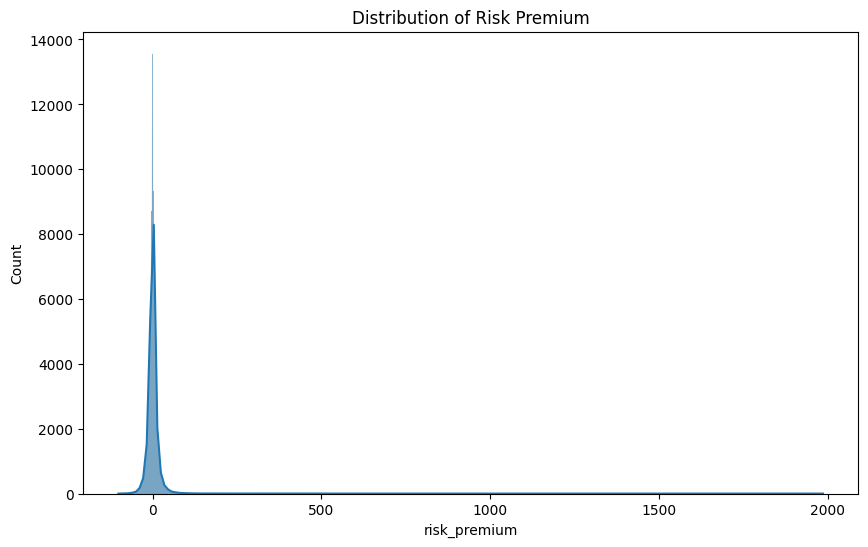

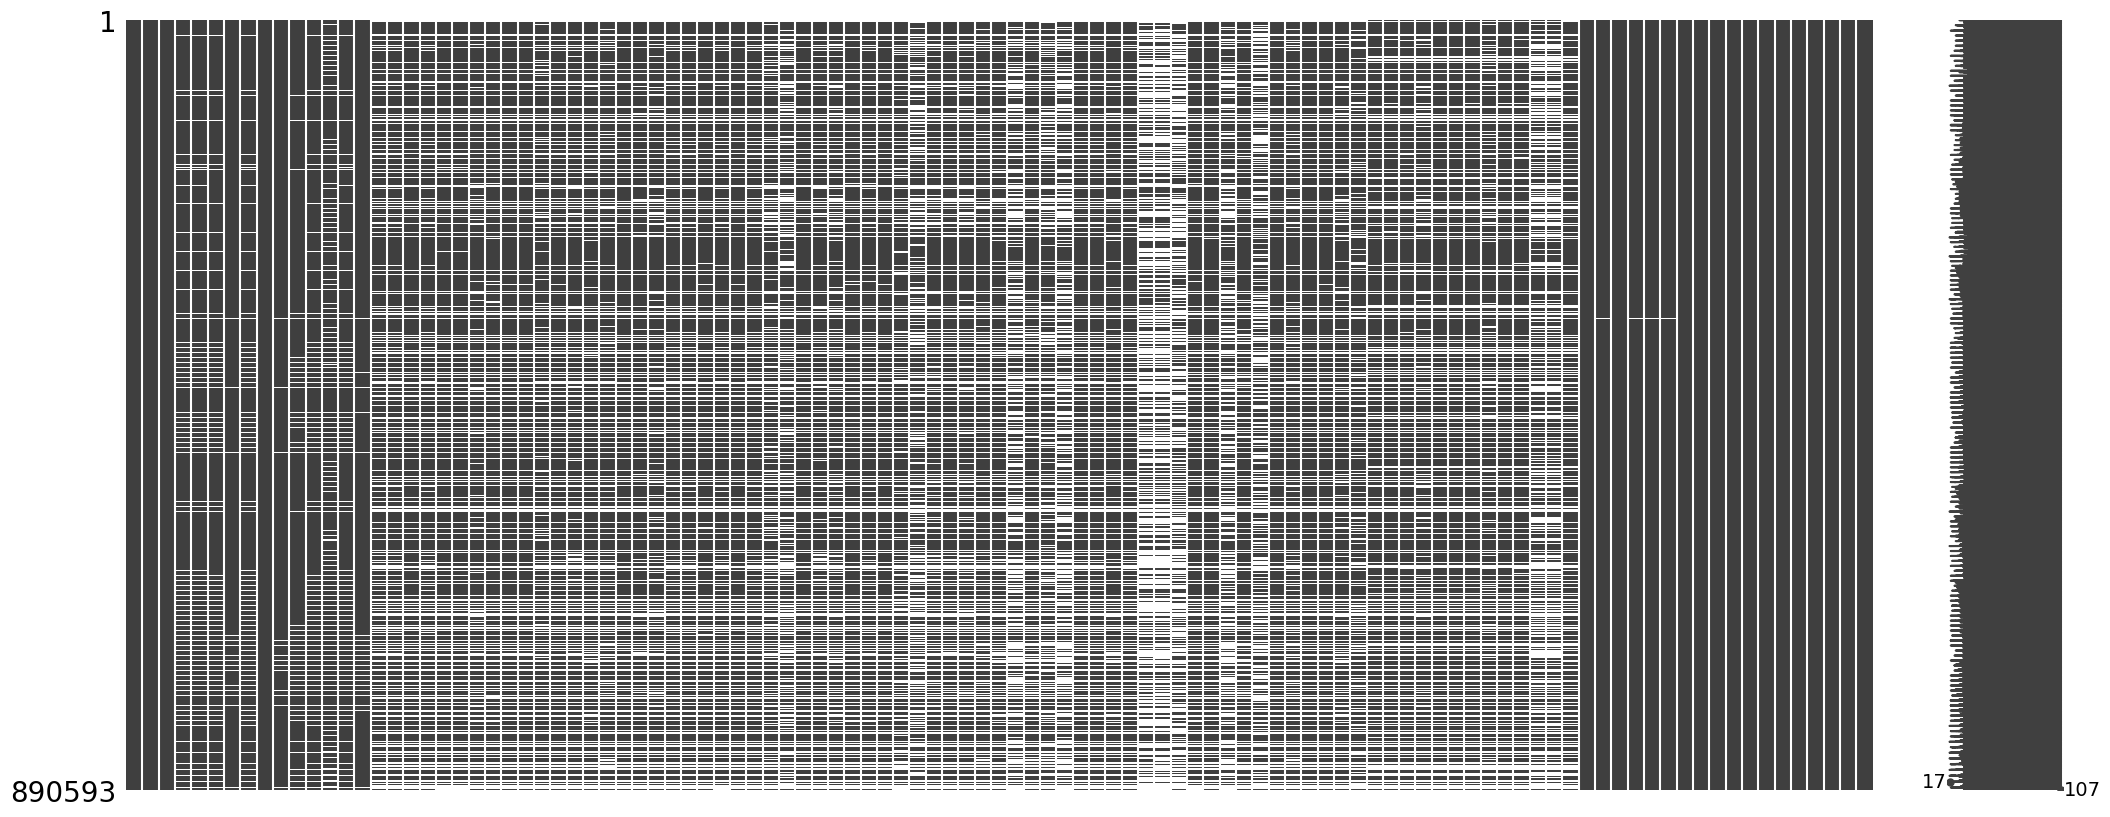

In [7]:
# Histogram of the target variable
plt.figure(figsize=(10,6))
sns.histplot(returns_sample['risk_premium'], kde=True)
plt.title('Distribution of Risk Premium')
plt.show()

# Visualize missing values
msno.matrix(returns_sample)
plt.show()

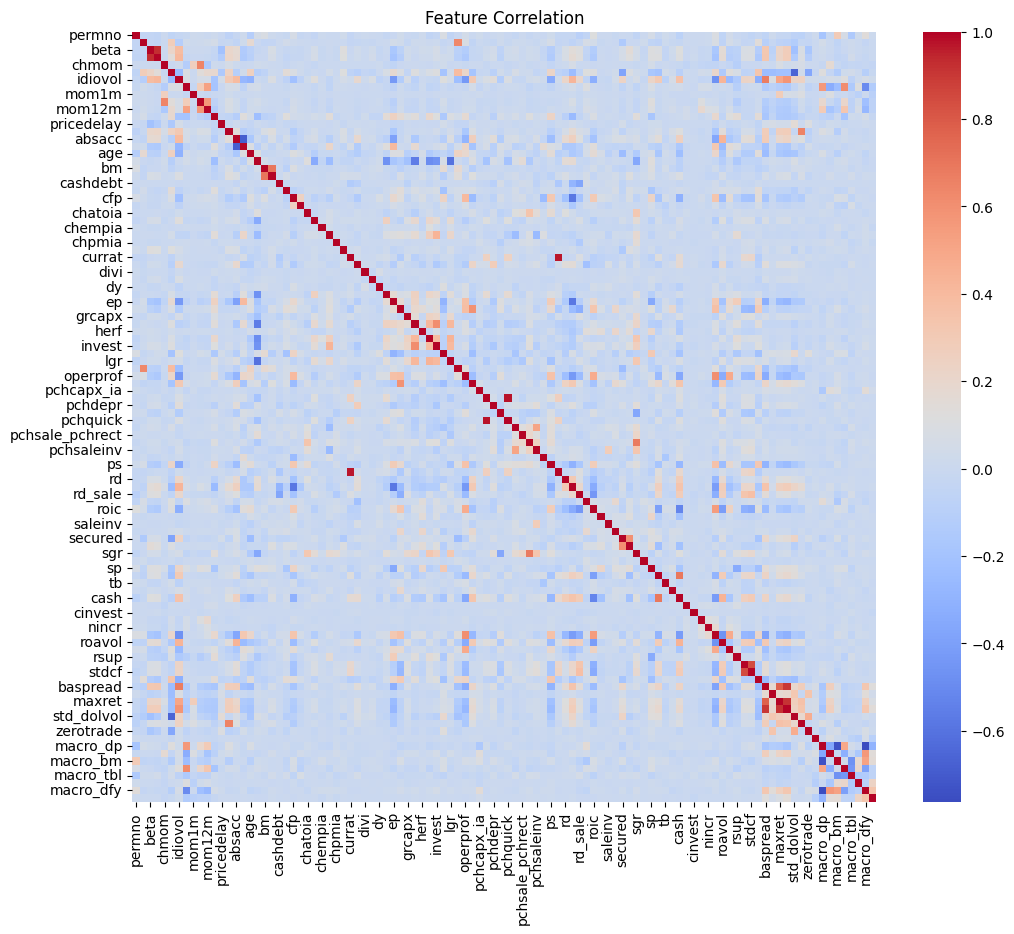

In [8]:
# Select only numeric columns
numeric_df = returns_sample.select_dtypes(include=[np.number])

# Plot the correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

## 4. Data Preprocessing

### 4.1 Handling Missing Values

In [9]:
# Check missing values
print(returns_sample.isnull().sum())

# Impute missing values
# For numerical features, use median; for categorical, use mode

# Identify numerical and categorical columns
numerical_cols = returns_sample.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = returns_sample.select_dtypes(exclude=[np.number]).columns.tolist()

# Remove the target variable and 'permno' from predictors list if present
if 'risk_premium' in numerical_cols:
    numerical_cols.remove('risk_premium')
if 'permno' in numerical_cols:
    numerical_cols.remove('permno')
if 'risk_premium' in categorical_cols:
    categorical_cols.remove('risk_premium')
if 'permno' in categorical_cols:
    categorical_cols.remove('permno')

# Impute numerical columns with median
for col in numerical_cols:
    median = returns_sample[col].median()
    returns_sample[col].fillna(median, inplace=True)

# Impute categorical columns with mode
for col in categorical_cols:
    mode = returns_sample[col].mode()
    if not mode.empty:
        returns_sample[col].fillna(mode[0], inplace=True)
    else:
        # If mode is empty (all values are NaN), fill with a placeholder
        returns_sample[col].fillna('Unknown', inplace=True)

# Verify no missing values remain
print('\nTotal Missing Values After Imputation:', returns_sample.isnull().sum().sum())

permno            0
DATE              0
mvel1           157
beta          61651
betasq        61651
              ...  
macro_ntis        0
macro_tbl         0
macro_tms         0
macro_dfy         0
macro_svar        0
Length: 107, dtype: int64


/tmp/ipykernel_12762/2190785268.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  returns_sample[col].fillna(median, inplace=True)
/tmp/ipykernel_12762/2190785268.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 


Total Missing Values After Imputation: 0


### 4.2 Feature Engineering

In [10]:
# Convert 'DATE' to datetime with specified format
returns_sample['DATE'] = pd.to_datetime(returns_sample['DATE'], format='%m/%d/%y')

# Sort the data based on 'DATE'
data_sorted = returns_sample.sort_values(by='DATE')

# Reset indices after sorting
data_sorted.reset_index(drop=True, inplace=True)

# Drop 'name' as it causes high cardinality issues
data_sorted = data_sorted.drop(['name'], axis=1)

# Separate features and target
X = data_sorted.drop(['DATE', 'risk_premium', 'permno'], axis=1)
y = data_sorted['risk_premium']

# Extract year and month from 'DATE'
X['year'] = data_sorted['DATE'].dt.year
X['month'] = data_sorted['DATE'].dt.month

# Create cyclical features for 'month' to capture seasonality
X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)

# Drop 'month' as it's encoded
X = X.drop(['month'], axis=1)

### 4.3 Splitting the Data into Training and Testing Sets

In [11]:
# Initial size of the training set (80% for training)
initial_train_size = int(len(X) * 0.8)

# Apply expanding window technique
X_train = X.iloc[:initial_train_size]
y_train = y.iloc[:initial_train_size]

X_test = X.iloc[initial_train_size:]
y_test = y.iloc[initial_train_size:]

print(f"Initial training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Initial training set size: (712474, 106)
Testing set size: (178119, 106)


## 5. Preprocessing Pipelines

In [12]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Identify numerical and categorical features based on X_train
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nCategorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data (using OrdinalEncoder)
if categorical_features:
    print("Applying Ordinal Encoding to categorical features.")
    categorical_transformer = OrdinalEncoder()
else:
    categorical_transformer = 'passthrough'

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


Categorical Features: ['sic2']
Numerical Features: ['mvel1', 'beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'indmom', 'mom1m', 'mom6m', 'mom12m', 'mom36m', 'pricedelay', 'turn', 'absacc', 'acc', 'age', 'agr', 'bm', 'bm_ia', 'cashdebt', 'cashpr', 'cfp', 'cfp_ia', 'chatoia', 'chcsho', 'chempia', 'chinv', 'chpmia', 'convind', 'currat', 'depr', 'divi', 'divo', 'dy', 'egr', 'ep', 'gma', 'grcapx', 'grltnoa', 'herf', 'hire', 'invest', 'lev', 'lgr', 'mve_ia', 'operprof', 'orgcap', 'pchcapx_ia', 'pchcurrat', 'pchdepr', 'pchgm_pchsale', 'pchquick', 'pchsale_pchinvt', 'pchsale_pchrect', 'pchsale_pchxsga', 'pchsaleinv', 'pctacc', 'ps', 'quick', 'rd', 'rd_mve', 'rd_sale', 'realestate', 'roic', 'salecash', 'saleinv', 'salerec', 'secured', 'securedind', 'sgr', 'sin', 'sp', 'tang', 'tb', 'aeavol', 'cash', 'chtx', 'cinvest', 'ear', 'nincr', 'roaq', 'roavol', 'roeq', 'rsup', 'stdacc', 'stdcf', 'ms', 'baspread', 'ill', 'maxret', 'retvol', 'std_dolvol', 'std_turn', 'zerotrade', 'macro_dp', 'macro_ep', '

### Define a Function to Train and Evaluate Models

In [13]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def train_and_evaluate_model(model_pipeline):
    # Train the model
    model_pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model_pipeline.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return mse, r2, mae, y_pred

# Define a function to plot the predicted vs. actual values
def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted Values')
    plt.show()
    
# Define a function to plot the residuals
def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=y_test, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Actual Values')
    plt.show()

# Plot all the defined plots
def plot_all(y_test, y_pred):
    plot_predictions(y_test, y_pred)
    plot_residuals(y_test, y_pred)

## 6. Model Building

### 6.1 Linear Regression

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Create a pipeline with preprocessing and Linear Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train and evaluate
mse_lr, r2_lr, mae_lr, y_pred_lr = train_and_evaluate_model(lr_pipeline)

print("Linear Regression Performance:")
print(f"Mean Squared Error: {mse_lr:.4f}")
print(f"R² Score: {r2_lr:.4f}")
print(f"Mean Absolute Error: {mae_lr:.4f}\n")

Linear Regression Performance:
Mean Squared Error: 526.1749
R² Score: -0.0609
Mean Absolute Error: 13.5496



### 6.2 Decision Tree Regressor

In [15]:
from sklearn.tree import DecisionTreeRegressor

# Initialize Decision Tree Regressor
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Train and evaluate
mse_dt, r2_dt, mae_dt, y_pred_dt = train_and_evaluate_model(dt_pipeline)

print("Decision Tree Regressor Performance:")
print(f"Mean Squared Error: {mse_dt:.4f}")
print(f"R² Score: {r2_dt:.4f}")
print(f"Mean Absolute Error: {mae_dt:.4f}\n")

Decision Tree Regressor Performance:
Mean Squared Error: 1038.1773
R² Score: -1.0933
Mean Absolute Error: 17.1189



### 6.3 Random Forest Regressor

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest Regressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Train and evaluate
mse_rf, r2_rf, mae_rf, y_pred_rf = train_and_evaluate_model(rf_pipeline)

print("Random Forest Regressor Performance:")
print(f"Mean Squared Error: {mse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")
print(f"Mean Absolute Error: {mae_rf:.4f}\n")

Random Forest Regressor Performance:
Mean Squared Error: 502.6280
R² Score: -0.0134
Mean Absolute Error: 11.3791



### 6.4 XGBoost Regressor

In [17]:
import xgboost as xgb

# Initialize XGBoost Regressor
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(
        random_state=42,
        objective='reg:squarederror',
        device='cuda',  # Use GPU acceleration
        tree_method='hist',  # Use GPU acceleration
        #predictor='predictor', # Note necessary anymore
    ))
])

# Train and evaluate
mse_xgb, r2_xgb, mae_xgb, y_pred_xgb = train_and_evaluate_model(xgb_pipeline)

print("XGBoost Regressor Performance:")
print(f"Mean Squared Error: {mse_xgb:.4f}")
print(f"R² Score: {r2_xgb:.4f}")
print(f"Mean Absolute Error: {mae_xgb:.4f}\n")

XGBoost Regressor Performance:
Mean Squared Error: 515.7646
R² Score: -0.0399
Mean Absolute Error: 11.3249



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:27] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### 6.5 LightGBM Regressor

In [19]:
import lightgbm as lgb

# Initialize LightGBM Regressor
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(
        random_state=42,
        n_jobs=-1,
        device='cpu'  # Use GPU
    ))
])

# Train and evaluate
mse_lgb, r2_lgb, mae_lgb, y_pred_lgb = train_and_evaluate_model(lgb_pipeline)

print("LightGBM Regressor Performance:")
print(f"Mean Squared Error: {mse_lgb:.4f}")
print(f"R² Score: {r2_lgb:.4f}")
print(f"Mean Absolute Error: {mae_lgb:.4f}\n")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22500
[LightGBM] [Info] Number of data points in the train set: 712474, number of used features: 105
[LightGBM] [Info] Start training from score 0.579041
LightGBM Regressor Performance:
Mean Squared Error: 488.5778
R² Score: 0.0149
Mean Absolute Error: 10.9417



### 6.6 CatBoost Regressor

In [20]:
import catboost as cb

# Initialize CatBoost Regressor
cb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', cb.CatBoostRegressor(
        random_state=42,
        verbose=0,
        task_type="GPU",  # Use GPU acceleration
        devices='0'
    ))
])

# Train and evaluate
mse_cb, r2_cb, mae_cb, y_pred_cb = train_and_evaluate_model(cb_pipeline)

print("CatBoost Regressor Performance:")
print(f"Mean Squared Error: {mse_cb:.4f}")
print(f"R² Score: {r2_cb:.4f}")
print(f"Mean Absolute Error: {mae_cb:.4f}\n")

CatBoost Regressor Performance:
Mean Squared Error: 495.4529
R² Score: 0.0010
Mean Absolute Error: 11.0310



### 6.7 AdaBoost Regressor with Multiprocessing CPUs

In [22]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

# Inizializza AdaBoost Regressor con un base_estimator ottimizzato per multicore
ada_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', AdaBoostRegressor(
        estimator=DecisionTreeRegressor(
            random_state=42,
            max_depth=3
        ),
        n_estimators=100,    # Numero di alberi
        learning_rate=0.1,   # Tasso di apprendimento
        random_state=42
    ))
])

# Allena e valuta
mse_ada, r2_ada, mae_ada, y_pred_ada = train_and_evaluate_model(ada_pipeline)

print("Prestazioni di AdaBoost Regressor (Multicore):")
print(f"Mean Squared Error: {mse_ada:.4f}")
print(f"R² Score: {r2_ada:.4f}")
print(f"Mean Absolute Error: {mae_ada:.4f}\n")


Prestazioni di AdaBoost Regressor (Multicore):
Mean Squared Error: 532.3386
R² Score: -0.0733
Mean Absolute Error: 11.8542



### 6.8 XGBoost Random Forest Regressor

In [23]:
# Set parameters for Random Forest with XGBoost
params = {
    "objective": "reg:squarederror",
    "learning_rate": 1,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bynode": 0.8,
    "num_parallel_tree": 100,
    "tree_method": "hist",
    "random_state": 42,
    "device": "cuda",
    "predictor": "gpu_predictor"
}

# Initialize XGBoost Random Forest Regressor
xgb_rf_regressor = xgb.XGBRegressor(**params, n_estimators=1)

# Create the pipeline
xgb_rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_rf_regressor)
])

# Train and evaluate
mse_rfx, r2_rfx, mae_rfx, y_pred_rfx = train_and_evaluate_model(xgb_rf_pipeline)

print("XGBoost Random Forest Regressor Performance:")
print(f"Mean Squared Error: {mse_rfx:.4f}")
print(f"R² Score: {r2_rfx:.4f}")
print(f"Mean Absolute Error: {mae_rfx:.4f}\n")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:31:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Random Forest Regressor Performance:
Mean Squared Error: 493.1193
R² Score: 0.0057
Mean Absolute Error: 10.9972



## 7. Evaluating Model Performance

In [24]:
# Create a DataFrame to compare model performances
performance_df = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Decision Tree',
        'Random Forest',
        'XGBoost',
        'LightGBM',
        'CatBoost',
        'AdaBoost',
        'XGBoost RF'
    ],
    'Mean Squared Error': [
        mse_lr,
        mse_dt,
        mse_rf,
        mse_xgb,
        mse_lgb,
        mse_cb,
        mse_ada,
        mse_rfx
    ],
    'Mean Absolute Error': [
        mae_lr,
        mae_dt,
        mae_rf,
        mae_xgb,
        mae_lgb,
        mae_cb,
        mae_ada,
        mae_rfx
    ],
    'R² Score': [
        r2_lr,
        r2_dt,
        r2_rf,
        r2_xgb,
        r2_lgb,
        r2_cb,
        r2_ada,
        r2_rfx
    ]
})

print("Model Performance Comparison:")
performance_df

Model Performance Comparison:


,Model,Mean Squared Error,Mean Absolute Error,R² Score
0,Linear Regression,526.174891,13.549635,-0.060914
1,Decision Tree,1038.177294,17.118884,-1.093252
2,Random Forest,502.627983,11.379111,-0.013437
3,XGBoost,515.764605,11.324924,-0.039924
4,LightGBM,488.577767,10.941750,0.014892
5,CatBoost,495.452879,11.030964,0.001030
6,AdaBoost,532.338609,11.854186,-0.073342
7,XGBoost RF,493.119267,10.997198,0.005735


## 8. Hyperparameter Tuning with RandomizedSearchCV

### 8.1 XGBoost Random Forest Regressor Hyperparameter Tuning

In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Define the pipeline with XGBRFRegressor
xgbrf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRFRegressor(tree_method='hist', device='cuda', random_state=42))
])

# Define the parameter grid for XGBRFRegressor
xgbrf_param_grid = {
    'regressor__n_estimators': [200, 400],
    'regressor__max_depth': [10, 20],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__subsample': [0.8, 1],
    'regressor__colsample_bynode': [0.8, 1]
}

# Initialize RandomizedSearchCV
xgbrf_random_search = RandomizedSearchCV(
    estimator=xgbrf_pipeline,
    param_distributions=xgbrf_param_grid,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

from joblib import parallel_backend

with parallel_backend('threading'):
    xgbrf_random_search.fit(X_train, y_train)


# Best parameters
print("Best parameters found: ", xgbrf_random_search.best_params_)

# Best estimator
best_xgbrf = xgbrf_random_search.best_estimator_

# Predict on test set with best estimator
y_pred_best_xgbrf = best_xgbrf.predict(X_test)

# Evaluate the best model
mse_best_xgbrf = mean_squared_error(y_test, y_pred_best_xgbrf)
r2_best_xgbrf = r2_score(y_test, y_pred_best_xgbrf)
mae_best_xgbrf = mean_absolute_error(y_test, y_pred_best_xgbrf)

print("\nBest XGBoost Random Forest Regressor Performance After Hyperparameter Tuning:")
print(f"Mean Squared Error: {mse_best_xgbrf:.4f}")
print(f"R² Score: {r2_best_xgbrf:.4f}")
print(f"Mean Absolute Error: {mae_best_xgbrf:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END regressor__colsample_bynode=1, regressor__learning_rate=0.1, regressor__max_depth=10, regressor__n_estimators=200, regressor__subsample=1; total time=  25.9s
[CV] END regressor__colsample_bynode=1, regressor__learning_rate=0.01, regressor__max_depth=10, regressor__n_estimators=200, regressor__subsample=1; total time=  25.9s
[CV] END regressor__colsample_bynode=1, regressor__learning_rate=0.1, regressor__max_depth=10, regressor__n_estimators=200, regressor__subsample=1; total time=  25.9s
[CV] END regressor__colsample_bynode=1, regressor__learning_rate=0.1, regressor__max_depth=20, regressor__n_estimators=400, regressor__subsample=0.8; total time=  25.9s
[CV] END regressor__colsample_bynode=0.8, regressor__learning_rate=0.1, regressor__max_depth=20, regressor__n_estimators=400, regressor__subsample=1; total time=  26.2s
[CV] END regressor__colsample_bynode=0.8, regressor__learning_rate=0.1, regressor__max_depth=10, re

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **las

Best parameters found:  {'regressor__subsample': 0.8, 'regressor__n_estimators': 200, 'regressor__max_depth': 10, 'regressor__learning_rate': 0.1, 'regressor__colsample_bynode': 0.8}

Best XGBoost Random Forest Regressor Performance After Hyperparameter Tuning:
Mean Squared Error: 494.3506
R² Score: 0.0033
Mean Absolute Error: 11.0771


### 8.2 XGBoost Regressor Hyperparameter Tuning

In [26]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__gamma': [0, 0.1, 0.2],
}

# Initialize RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_grid,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit RandomizedSearchCV
xgb_random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found for XGBoost: ", xgb_random_search.best_params_)

# Best estimator
best_xgb = xgb_random_search.best_estimator_

# Predict on test set with best estimator
y_pred_best_xgb = best_xgb.predict(X_test)

# Evaluate the best model
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)

print("\nBest XGBoost Regressor Performance After Hyperparameter Tuning:")
print(f"Mean Squared Error: {mse_best_xgb:.4f}")
print(f"R² Score: {r2_best_xgb:.4f}")
print(f"Mean Absolute Error: {mae_best_xgb:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:48:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:48:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

Best parameters found for XGBoost:  {'regressor__subsample': 0.6, 'regressor__n_estimators': 200, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Best XGBoost Regressor Performance After Hyperparameter Tuning:
Mean Squared Error: 485.4636
R² Score: 0.0212
Mean Absolute Error: 10.8227


## 9. Feature Importance Analysis

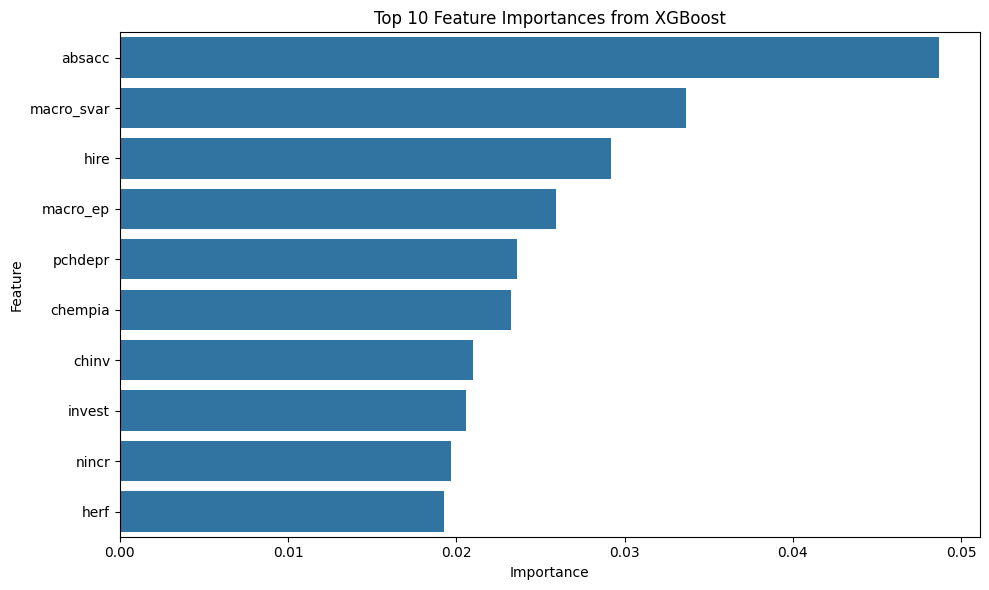

In [27]:
# Combine numerical and categorical feature names
feature_names = numerical_features + categorical_features

# Get feature importances
importances = best_xgb.named_steps['regressor'].feature_importances_

# Ensure the lengths match
if len(feature_names) != len(importances):
    raise ValueError("Length of feature names and importances must match.")

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame based on importance
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances from XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 10. SHAP Values for Model Interpretation

In [28]:
# Load JS visualization code to render SHAP plots in notebooks
shap.initjs()

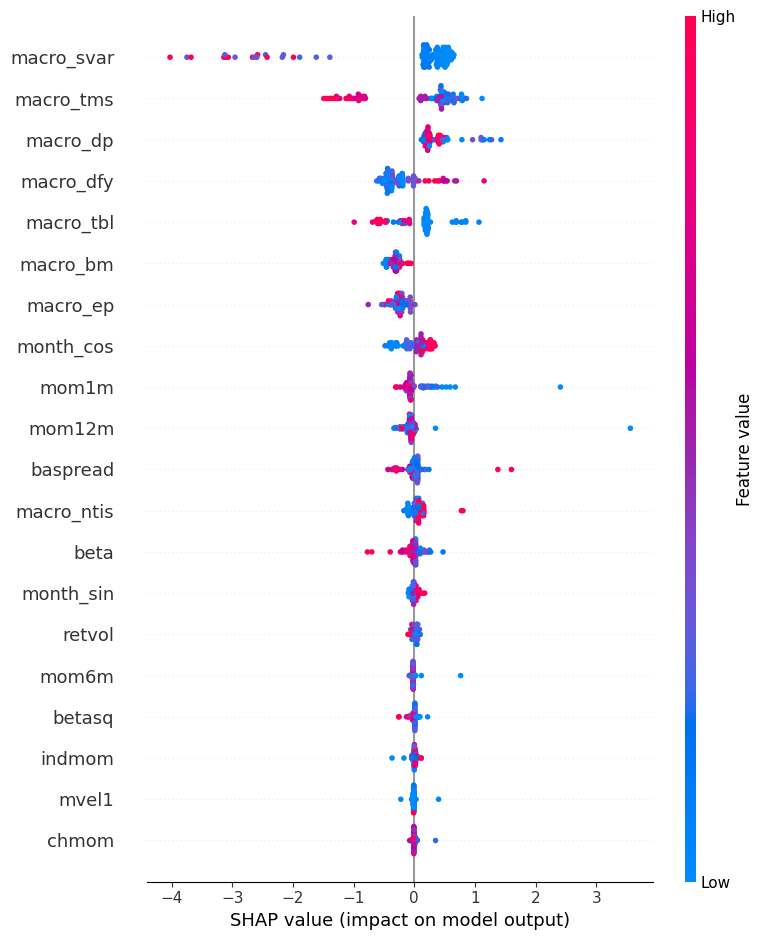

In [29]:
# Prepare sample data for SHAP
X_sample = X_test.sample(100, random_state=42)  # Use a smaller sample for efficiency
y_sample = y_test.loc[X_sample.index]

# Preprocess the sample data
X_sample_processed = best_xgb.named_steps['preprocessor'].transform(X_sample)

# Ensure that X_sample_processed is a numpy array of float64
X_sample_processed = np.array(X_sample_processed, dtype=np.float64)

# Initialize the SHAP explainer
explainer = shap.Explainer(best_xgb.named_steps['regressor'])

# Calculate SHAP values
shap_values = explainer(X_sample_processed)

# Summary plot
shap.summary_plot(shap_values, features=X_sample_processed, feature_names=feature_names)

## 11. Neural Network Implementation with GPU Acceleration

2024-11-28 19:48:59.411067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10728 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:42:00.0, compute capability: 8.9
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


I0000 00:00:1732823343.256117   15339 service.cc:145] XLA service 0x2c91eb40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732823343.256219   15339 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-28 19:49:03.310364: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-28 19:49:03.551990: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  53/2784 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 666.1937 - mae: 16.7211

I0000 00:00:1732823348.284442   15339 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2784/2784 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 352.0655 - mae: 10.6453 - val_loss: 491.2068 - val_mae: 10.8970
Epoch 2/100
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 351.0525 - mae: 10.5941 - val_loss: 497.5776 - val_mae: 11.0478
Epoch 3/100
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 350.3141 - mae: 10.5747 - val_loss: 500.9108 - val_mae: 11.1636
Epoch 4/100
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 349.6096 - mae: 10.5855 - val_loss: 496.2851 - val_mae: 11.0600
Epoch 5/100
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 349.5616 - mae: 10.5708 - val_loss: 512.8214 - val_mae: 11.3210
Epoch 6/100
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 347.2984 - mae: 10.5749 - val_loss: 501.8826 - val_mae: 11.3916
Epoch 7/100
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 346.0555 - mae: 10.5702 - val_loss: 508.7905 - val_mae: 11.5145
Epoch 8/100
2784/2784 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 345.4243 - mae: 10.5521 - val_loss: 511.3690 - val_mae: 11.

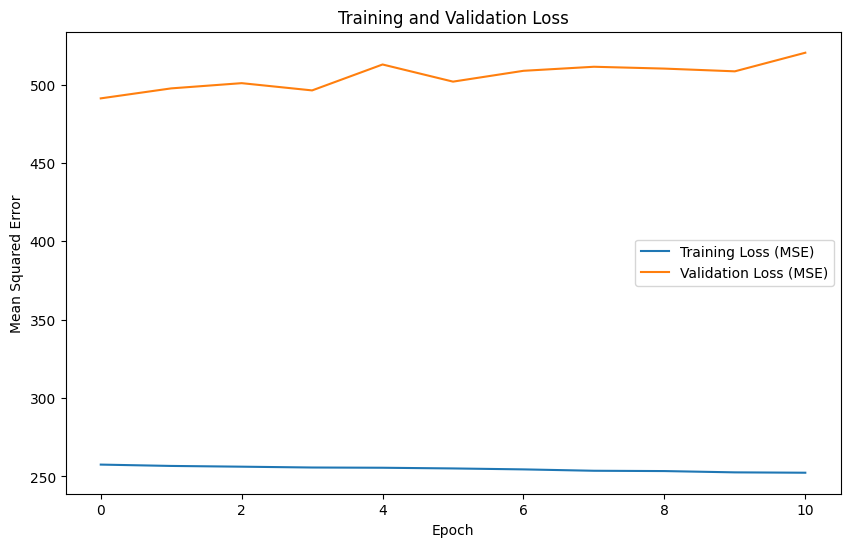

In [30]:
# Clear TensorFlow session
tf.keras.backend.clear_session()

# Apply preprocessing to the entire dataset
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to TensorFlow datasets for efficient loading and prefetching
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_processed, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_processed, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Define the neural network architecture
def create_model():
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(X_train_processed.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])
    return model

model = create_model()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Define early stopping and model checkpoint
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True
)

# Train the model using GPU acceleration
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint_cb],
    verbose=1
)

# Load the best model
model = keras.models.load_model("best_model.keras")

# Evaluate the model
loss, mae = model.evaluate(test_dataset)
print(f"\nNeural Network Performance:")
print(f"Mean Squared Error: {loss:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot training & validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()